In [122]:
import json
import gzip
from collections import defaultdict, OrderedDict, Counter
from transformers import AutoTokenizer, pipeline
from optimum.onnxruntime import ORTModelForTokenClassification
import argparse
from tqdm import tqdm
import onnxruntime as ort
import torch
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
from dotenv import load_dotenv
from itertools import islice

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)




SECTIONS_MAP = {
    "TITLE": "Title",
    "ABSTRACT": "Abstract",
    "INTRO": "Introduction",
    "METHODS": "Methods",
    "RESULTS": "Results",
    "DISCUSS": "Discussion",
    "CONCL": "Conclusion",
    "CASE": "Case study",
    "ACK_FUND": "Acknowledgments",
    "AUTH_CONT": "Author Contributions",
    "COMP_INT": "Competing Interests",
    "ABBR": "Abbreviations",
    "SUPPL": "Supplementary material",
    "REF": "References",
    "TABLE": "Table",
    "FIGURE": "Figure",
    "DATA SHARING STATEMENT": "Data Availability",
    "APPENDIX": "Appendix",
    "OTHER": "Other"
}



PROVIDER = "Metagenomics"
PARALLEL_ = True



In [57]:
def get_word_position(sent_id, sentence_text, char_start):
    """
    Calculate the word position based on character start index.
    Returns a string in the format 'sent_id.word_position'.
    """
    words = sentence_text.split()
    current_char = 0
    for idx, word in enumerate(words):
        word_start = sentence_text.find(word, current_char)
        if word_start == char_start:
            return f"{sent_id}.{idx + 1}"
        current_char = word_start + len(word)
    return f"{sent_id}.0"  # Return 0 if position not found


def get_prefix_postfix(sentence_text, char_start, char_end, num_words=3, max_chars=30):
    """
    Extract prefix and postfix based on word positions with constraints:
    - Returns up to `num_words` before and after the target term.
    - Ensures each prefix and postfix does not exceed `max_chars`.
    """
    words = sentence_text.split()
    word_positions = [sentence_text.find(word) for word in words]

    # Identify the word index for the starting character of the entity
    word_index = None
    for idx, start in enumerate(word_positions):
        if start == char_start:
            word_index = idx
            break

    prefix, postfix = "", ""
    if word_index is not None:
        # Extract prefix words up to `num_words` or `max_chars`
        prefix_words = words[max(0, word_index - num_words):word_index]
        prefix = ' '.join(prefix_words)
        if len(prefix) > max_chars:
            prefix = prefix[-max_chars:]  # Truncate to the last `max_chars` characters

        # Extract postfix words up to `num_words` or `max_chars`
        postfix_words = words[word_index + 1:word_index + 1 + num_words]
        postfix = ' '.join(postfix_words)
        if len(postfix) > max_chars:
            postfix = postfix[:max_chars]  # Truncate to the first `max_chars` characters

    return prefix, postfix

# Helper function to batch sentences into chunks of size n
def batch_sentences(iterable, n=4):
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            break
        yield batch

def extract_annotation(sentence_id, sentence_text, entity, section):
    term = sentence_text[entity['start']:entity['end']]
    position = get_word_position(sentence_id, sentence_text, entity['start'])
    prefix, postfix = get_prefix_postfix(sentence_text, entity['start'], entity['end'])
    full_entity_type = entity["entity_group"]

    return {
        "type": full_entity_type,
        "position": position,
        "prefix": prefix,
        "exact": term,
        "section": section,
        "postfix": postfix
    }

# Annotate sentences in batches and count entity frequency
def batch_annotate_sentences(sentences, section, ner_model, parallel=PARALLEL_):
    annotations = []

    if parallel:
        # Process in batches of at least 4 sentences
        for sentence_batch in batch_sentences(sentences, n=4):
            batched_text = [s["text"] for s in sentence_batch]
            ner_results = ner_model(batched_text)

            for i, sentence_entities in enumerate(ner_results):
                sentence_id = sentence_batch[i]["sent_id"]
                sentence_text = sentence_batch[i]["text"]
                for entity in sentence_entities:
                    annotations.append(extract_annotation(sentence_id, sentence_text, entity, section))
    else:
        # Process sentences individually
        for sentence in sentences:
            ner_results = ner_model([sentence["text"]])[0]
            sentence_id = sentence["sent_id"]
            sentence_text = sentence["text"]
            for entity in ner_results:
                annotations.append(extract_annotation(sentence_id, sentence_text, entity, section))

    return annotations

def generate_tags(all_annotations):
    """
    Generate tags for each annotation in all_annotations using normalize_tag for term normalization and URL generation.
    Each annotation will have 'name' and 'uri' fields in the 'tags' list.
    """
    output_annotations = []

    # Generate tags for each annotation
    for annotation in all_annotations:
        entity_type = annotation['type']
        term = annotation['exact']

        # Normalize the term to get the URI using normalize_tag
        uri = normalize_tag(term, entity_type)
        
        # Add the annotation with tags, using "#" if no URI was found
        output_annotations.append({
            "type": entity_type,
            "position": annotation["position"],
            "prefix": annotation["prefix"],
            "exact": term,
            "section": annotation["section"],
            "postfix": annotation["postfix"],
            "tags": [
                {
                    "name": term,
                    "uri": uri if uri != "#" else "#"  # Use "#" if no valid URI is found
                }
            ]
        })

    return output_annotations



def format_output_annotations(all_linked_annotations_, pmcid, ft_id):
    """
    Formats output annotations into two JSON structures:
    - 'match_json' for matched annotations
    - 'non_match_json' for unmatched annotations
    """
    match_annotations = []
    non_match_annotations = []

    # Separate annotations based on tags
    for annotation in all_linked_annotations_:
        # Check if the annotation is unmatched (name and uri are '#')
        if annotation["tags"][0]["uri"].endswith("#"):
            non_match_annotations.append(annotation)
        else:
            match_annotations.append(annotation)

    # Construct final JSON outputs
    match_json = OrderedDict()
    non_match_json = OrderedDict()

    # Add pmcid or ft_id to both match and non-match JSONs
    if pmcid:
        match_json["pmcid"] = pmcid
        non_match_json["pmcid"] = pmcid
    elif ft_id:
        match_json["ft_id"] = ft_id
        non_match_json["ft_id"] = ft_id

    # Add provider and anns fields to each JSON
    match_json["provider"] = "europepmc"
    match_json["anns"] = match_annotations

    non_match_json["provider"] = "europepmc"
    non_match_json["anns"] = non_match_annotations

    return match_json, non_match_json


def count_lines_in_gzip(file_path):
    """Counts the lines in a gzipped file."""
    with gzip.open(file_path, "rt") as f:
        return sum(1 for _ in f)


In [114]:
# Main function for processing article and generating JSONs
def process_article_generate_jsons(article_data, parallel=PARALLEL_):
    article_type = article_data.get("article_type", "").lower()
    if "research" not in article_type:
        # print(article_type)
        return None, None  # Skip non-research articles

    pmcid = article_data.get("article_ids", {}).get("pmcid")
    ft_id = article_data.get("article_ids", {}).get("archive") or article_data.get("article_ids", {}).get("manuscript")

    if not pmcid and not ft_id:
        return None, None  # Skip article if no pmcid or ft_id

    # Retrieve and join sentences from the ABSTRACT section
    abstract_section = article_data.get("sections", {}).get("ABSTRACT", [])
    # Ensure each item in abstract_section is a string by extracting the 'text' key
    abstract_text_list = [sentence["text"] for sentence in abstract_section if "text" in sentence]
    # Join the abstract text
    abstract_text = " ".join(abstract_text_list)

    # Classify the article based on the abstract
    predicted_label, proba = classify_sentence(abstract_text)

    if predicted_label != "metagenomics" or (predicted_label == "metagenomics" and proba<0.65):
        return None, None  # Skip NER tagging if label is "other"
    
    all_annotations = []
    print([article_type,pmcid,predicted_label, proba])
    # Loop through each NER model for the specified sections
    for model in ner_models:
        # print(model)
        for section_key, sentences in article_data.get("sections", {}).items():
            if section_key not in ["INTRO", "METHODS", "RESULTS", "DISCUSS"]:
                continue  # Skip all sections except the specified ones

            section = SECTIONS_MAP.get(section_key, "Other")
            # Pass the NER model and parallel flag to batch_annotate_sentences
            batch_annotations = batch_annotate_sentences(sentences, section, ner_model=model, parallel=parallel)
            if not batch_annotations:
                continue

            all_annotations.extend(batch_annotations)

    # Generate tags for annotations - this includes grounded terms and grounded codes.
    all_linked_annotations = generate_tags(all_annotations)
    # Format matched and unmatched JSON structures
    match_json, non_match_json = format_output_annotations(all_linked_annotations, pmcid=pmcid, ft_id=ft_id)

    # Return None if both JSONs are empty or have empty 'anns' lists
    if not match_json["anns"] and not non_match_json["anns"]:
        return None, None

    return match_json, non_match_json


In [115]:
# Adjustments to `process_each_article` to ensure compatibility with the modified `process_article_generate_jsons`

def process_each_article(input_file, output_dir):
    # Create base output filenames based on input filename
    input_filename = os.path.basename(input_file).replace(".json.gz", "")
    output_file = os.path.join(output_dir, f"{input_filename}.json")
    no_match_file_path = os.path.join(output_dir, "no_matches", f"{input_filename}_no_match.json")

    # Count the total number of lines for the progress bar
    total_lines = count_lines_in_gzip(input_file)

    # Ensure no_matches directory exists
    os.makedirs(os.path.join(output_dir, "no_matches"), exist_ok=True)

    with gzip.open(input_file, "rt") as infile:
        # Use tqdm with the total number of lines
        for line in tqdm(infile, desc="Processing lines", unit="line", total=total_lines):
            article_data = json.loads(line)

            # Generate matched and unmatched JSONs
            match_json, non_match_json = process_article_generate_jsons(article_data)

            # Write match_json to the output file if it exists
            if match_json and match_json["anns"]:
                with open(output_file, "a", encoding="utf-8") as match_file:
                    json.dump(match_json, match_file, ensure_ascii=False)
                    match_file.write("\n")

            # Write non_match_json to the no_match file if it exists
            if non_match_json and non_match_json["anns"]:
                with open(no_match_file_path, "a", encoding="utf-8") as no_match_file_handler:
                    json.dump(non_match_json, no_match_file_handler, ensure_ascii=False)
                    no_match_file_handler.write("\n")

    print(f"Processing completed. Results saved to {output_file}")
    print(f"No match results saved to {no_match_file_path}")



import torch
from torch.nn.functional import softmax

def classify_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    article_model.eval()
    with torch.no_grad():
        outputs = article_model(**inputs)
    logits = outputs.logits
    
    # Calculate probabilities from logits
    probabilities = softmax(logits, dim=1)
    
    # Get the predicted class and its probability
    predicted_class = torch.argmax(logits, dim=1).item()
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    predicted_probability = probabilities[0, predicted_class].item()
    
    return predicted_label, predicted_probability


In [116]:
    # Set ONNX runtime session options
    session_options = ort.SessionOptions()
    session_options.intra_op_num_threads = 1  # Limit to a single thread
    session_options.inter_op_num_threads = 1  # Limit to a single thread

    # Load environment variables
    load_dotenv('/home/stirunag/work/github/CAPITAL/daily_pipeline/.env_paths')
    ml_model_path = os.getenv("MODEL_PATH_QUANTIZED")

    # Define paths
    article_model_path = ml_model_path + 'article_classifier/best_contrastive_binary_model_absurd-sweep-98.pth'
    article_label_encoder_path = ml_model_path + 'article_classifier/best_label_encoder_absurd-sweep-98.pkl'
    pretrained_model_name = "bioformers/bioformer-8L"

    # Define paths
    metagenomic_paths = [
        ml_model_path + f'metagenomics/metagenomic-set-{i}_quantised' for i in range(1, 6)
    ]
    article_model_path = ml_model_path + 'article_classifier/best_contrastive_binary_model_absurd-sweep-98.pth'
    article_label_encoder_path = ml_model_path + 'article_classifier/best_label_encoder_absurd-sweep-98.pkl'
    pretrained_model_name = "bioformers/bioformer-8L"

    # Function to load an ONNX NER model
    def load_ner_model(model_path, session_options):
        model = ORTModelForTokenClassification.from_pretrained(
            model_path, file_name="model_quantized.onnx", session_options=session_options
        )
        tokenizer = AutoTokenizer.from_pretrained(
            model_path, model_max_length=512, batch_size=4, truncation=True
        )
        return pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="max")

    # Load all NER models
    ner_models = [load_ner_model(path, session_options) for path in metagenomic_paths]
    print("All NER models loaded successfully.")

    # Load the article classifier model
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    article_model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
    article_model.load_state_dict(torch.load(article_model_path, map_location=torch.device('cpu')), strict=False)

    # Load the label encoder
    with open(article_label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)

    print("Article classifier model and label encoder loaded successfully.")


All NER models loaded successfully.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bioformers/bioformer-8L and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Article classifier model and label encoder loaded successfully.


In [117]:
# Directly assign the paths
input_path = "/home/stirunag/work/github/CAPITAL/daily_pipeline/notebooks/data/patch_2024_10_28_0.json.gz"  # Replace with your actual input file path
output_path = "/home/stirunag/work/github/CAPITAL/daily_pipeline/results/metagenomics/"  # Replace with your actual output directory path

In [118]:
# Check that input is a file
if not os.path.isfile(input_path):
    raise ValueError(f"Expected a file for input, but got: {input_path}")

# Check if output directory exists; if not, create it
if not os.path.isdir(output_path):
    print(f"Output directory '{output_path}' does not exist. Creating it.")
    os.makedirs(output_path, exist_ok=True)

# Ensure 'no_matches' directory exists within the output directory
no_match_dir = os.path.join(output_path, "no_matches")
os.makedirs(no_match_dir, exist_ok=True)
no_match_file_path = os.path.join(no_match_dir, "patch_no_match.json")



In [119]:
import pandas as pd
from pathlib import Path
from urllib.parse import urlparse
import requests


def normalize_tag(trm, entity):
    # Set default URL to "#" to indicate no match if no updates are made later in the function
    ourl = "#"
    
    try:
        if entity not in ['primer', 'kit']:
            url = 'https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate?propertyValue=' + trm         
            response = requests.get(url)
            
            # Check for successful response
            if response.status_code == 200:
                try:
                    rjson = response.json()
                    if rjson:
                        rslt = rjson[0]
                        lnk = rslt['_links']['olslinks'][0]
                        gurl = lnk.get('semanticTag', [])
                        
                        if 'http://purl.obolibrary.org/obo/' in gurl:
                            db_id = urlparse(gurl).path.split('/')[2:3][0]            
                            db = db_id.split('_')[0]                       
                            ourl = f'https://www.ebi.ac.uk/ols/ontologies/{db}/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2F{db_id}'           
                        else:
                            ourl = gurl
                except ValueError as e:
                    print(f"{trm}: error - Failed to parse JSON - {e}")
            else:
                print(f"{trm}: error - HTTP status code {response.status_code}")
        
        elif entity == 'kit':
            trm = trm.replace(' ', '-')
            ourl = 'https://www.biocompare.com/General-Search/?search=' + trm

        elif entity == 'primer':
            csvf = Path('xrf/probebase/primer_probebase.csv')
            if csvf.exists(): 
                prmdf = pd.read_csv(csvf)
                for p, prm in enumerate(prmdf['NAME']):
                    if (prm in trm) or (trm == prm):
                        ourl = list(prmdf['URL'])[p]
                        break
    except Exception as e:
        print(f"{trm}: error - {e}")
        pass

    return ourl


In [120]:
input_file =input_path
output_dir=output_path

In [121]:
input_filename = os.path.basename(input_file).replace(".json.gz", "")
output_file_OA = os.path.join(output_dir, f"{input_filename}_OA.json")
output_file_NOA = os.path.join(output_dir, f"{input_filename}_NOA.json")
no_match_file_OA = os.path.join(output_dir, "no_matches", f"{input_filename}_OA_no_match.json")
no_match_file_NOA = os.path.join(output_dir, "no_matches", f"{input_filename}_NOA_no_match.json")

total_lines = count_lines_in_gzip(input_file)

with gzip.open(input_file, "rt") as infile, \
     open(output_file_OA, "w", encoding="utf-8") as outfile_OA, \
     open(output_file_NOA, "w", encoding="utf-8") as outfile_NOA:

    for line in tqdm(infile, desc="Processing lines", unit="line", total=total_lines):
        article_data = json.loads(line)
        open_status = article_data.get("open_status", "")
        suffix = "_OA" if open_status in ["O", "OA"] else "_NOA"

        # Generate matched and unmatched JSONs
        match_json, non_match_json = process_article_generate_jsons(article_data)

        # Apply modifications if the article is restricted
        if suffix == "_NOA":
            if match_json:
                match_json = modify_restricted_json(match_json, open_status)
            if non_match_json:
                non_match_json = modify_restricted_json(non_match_json, open_status)

        # Write match_json and non_match_json to their respective files if they exist
        if match_json and match_json["anns"]:
            output_file = outfile_OA if suffix == "_OA" else outfile_NOA
            json.dump(match_json, output_file, ensure_ascii=False)
            output_file.write("\n")

        if non_match_json and non_match_json["anns"]:
            no_match_file_path = no_match_file_OA if suffix == "_OA" else no_match_file_NOA
            with open(no_match_file_path, "a", encoding="utf-8") as no_match_file:
                json.dump(non_match_json, no_match_file, ensure_ascii=False)
                no_match_file.write("\n")

print(f"Processing completed. OA results saved to {output_file_OA} and NOA results saved to {output_file_NOA}")
print(f"No match results saved to {no_match_file_OA} and {no_match_file_NOA}")

Processing lines:   2%|▏         | 20/909 [00:01<00:50, 17.72line/s]

['research-article', '10306258', 'metagenomics', 0.6059862375259399]
-: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:   4%|▍         | 39/909 [00:18<02:53,  5.01line/s]

['research-article', '10478259', 'metagenomics', 0.6599136590957642]


Processing lines:   4%|▍         | 39/909 [00:33<02:53,  5.01line/s]

-: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:   5%|▍         | 41/909 [00:46<1:02:01,  4.29s/line]

['research-article', '10071977', 'metagenomics', 0.615287184715271]
-: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  12%|█▏        | 105/909 [01:19<01:20,  9.94line/s] 

['research-article', '11256070', 'metagenomics', 0.6321286559104919]


Processing lines:  12%|█▏        | 105/909 [01:33<01:20,  9.94line/s]

-: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  13%|█▎        | 121/909 [02:24<17:03,  1.30s/line]  

['research-article', '10527998', 'metagenomics', 0.7855987548828125]


Processing lines:  15%|█▌        | 139/909 [02:45<03:02,  4.22line/s]

['research-article', '11259156', 'metagenomics', 0.6335421800613403]


Processing lines:  16%|█▋        | 148/909 [03:17<16:05,  1.27s/line]

['research-article', '10249757', 'metagenomics', 0.6326107382774353]


Processing lines:  17%|█▋        | 150/909 [04:11<1:46:23,  8.41s/line]

['research-article', '11262622', 'metagenomics', 0.6344352960586548]


Processing lines:  19%|█▉        | 175/909 [05:04<04:46,  2.56line/s]  

['research-article', '10516340', 'metagenomics', 0.6041818857192993]


Processing lines:  21%|██        | 188/909 [07:35<33:04,  2.75s/line]  

['research-article', '10361916', 'metagenomics', 0.6768805980682373]


Processing lines:  22%|██▏       | 200/909 [08:46<10:38,  1.11line/s]  

['research-article', '10529400', 'metagenomics', 0.7079651355743408]
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  23%|██▎       | 213/909 [09:23<04:02,  2.87line/s]  

['research-article', '11245991', 'metagenomics', 0.6220014691352844]
2.: error - Expecting value: line 1 column 1 (char 0)
.: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  27%|██▋       | 242/909 [13:54<01:34,  7.07line/s]   

['research-article', '11195804', 'metagenomics', 0.6864112019538879]


Processing lines:  27%|██▋       | 242/909 [14:13<01:34,  7.07line/s]

/: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  34%|███▍      | 313/909 [18:04<00:46, 12.84line/s]  

['research-article', '10484394', 'metagenomics', 0.7030308246612549]
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  34%|███▍      | 313/909 [18:23<00:46, 12.84line/s]

-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  37%|███▋      | 334/909 [18:46<01:47,  5.36line/s]

['research-article', '11292052', 'metagenomics', 0.6179831624031067]
.: error - Expecting value: line 1 column 1 (char 0)
to: error - Expecting value: line 1 column 1 (char 0)
.: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  40%|███▉      | 363/909 [21:07<01:35,  5.75line/s]  

['research-article', '10523879', 'metagenomics', 0.6072413921356201]


Processing lines:  47%|████▋     | 431/909 [23:04<01:15,  6.33line/s]  

['research-article', '11338178', 'metagenomics', 0.6383677124977112]


Processing lines:  50%|█████     | 455/909 [23:28<00:56,  8.10line/s]

['research-article', '10249652', 'metagenomics', 0.6696133017539978]


Processing lines:  52%|█████▏    | 477/909 [23:31<00:43,  9.89line/s]

['research-article', '11267293', 'metagenomics', 0.6374278664588928]


Processing lines:  52%|█████▏    | 477/909 [23:43<00:43,  9.89line/s]

-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  59%|█████▊    | 533/909 [25:16<02:38,  2.37line/s]  

['research-article', '10276171', 'metagenomics', 0.6062343716621399]


Processing lines:  61%|██████    | 554/909 [25:26<00:56,  6.24line/s]

['research-article', '11296043', 'metagenomics', 0.6316725611686707]


Processing lines:  64%|██████▎   | 578/909 [26:50<01:12,  4.55line/s]  

['research-article', '11287085', 'metagenomics', 0.6055004000663757]


Processing lines:  64%|██████▍   | 585/909 [27:14<09:58,  1.85s/line]

['research-article', '11312271', 'metagenomics', 0.6156858205795288]
+: error - Expecting value: line 1 column 1 (char 0)
+: error - Expecting value: line 1 column 1 (char 0)
_: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  67%|██████▋   | 605/909 [29:51<05:10,  1.02s/line]  

['research-article', '10504883', 'metagenomics', 0.6104469299316406]


Processing lines:  68%|██████▊   | 615/909 [30:21<04:47,  1.02line/s]

['research-article', '11308657', 'metagenomics', 0.7115412950515747]


Processing lines:  70%|███████   | 638/909 [32:16<00:50,  5.35line/s]  

['research-article', '11268072', 'metagenomics', 0.6654894948005676]


Processing lines:  74%|███████▍  | 676/909 [33:41<00:26,  8.69line/s]  

['research-article', '11292673', 'metagenomics', 0.6211218237876892]


Processing lines:  76%|███████▋  | 694/909 [34:20<00:51,  4.21line/s]

['research-article', '10601359', 'metagenomics', 0.6080634593963623]


Processing lines:  77%|███████▋  | 701/909 [34:43<04:47,  1.38s/line]

['research-article', '11308890', 'metagenomics', 0.6098644137382507]


Processing lines:  77%|███████▋  | 701/909 [34:53<04:47,  1.38s/line]

-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  77%|███████▋  | 703/909 [35:46<35:38, 10.38s/line]

['research-article', '11301353', 'metagenomics', 0.6325847506523132]


Processing lines:  77%|███████▋  | 703/909 [36:03<35:38, 10.38s/line]

%: error - Expecting value: line 1 column 1 (char 0)
/: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  81%|████████  | 738/909 [37:11<00:36,  4.68line/s]

['research-article', '10463236', 'metagenomics', 0.6382157206535339]


Processing lines:  82%|████████▏ | 744/909 [37:39<05:36,  2.04s/line]

['research-article', '11309005', 'metagenomics', 0.6721659302711487]


Processing lines:  82%|████████▏ | 746/909 [37:55<08:47,  3.23s/line]

['research-article', '11345318', 'metagenomics', 0.7456997036933899]


Processing lines:  85%|████████▍ | 772/909 [39:05<00:56,  2.43line/s]

['research-article', '11352519', 'metagenomics', 0.6290491223335266]


Processing lines:  85%|████████▍ | 772/909 [39:23<00:56,  2.43line/s]

-: error - Expecting value: line 1 column 1 (char 0)
/: error - Expecting value: line 1 column 1 (char 0)
to: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  86%|████████▋ | 786/909 [42:01<03:09,  1.54s/line]  

['research-article', '11307318', 'metagenomics', 0.6153221130371094]


Processing lines:  87%|████████▋ | 792/909 [43:19<08:14,  4.23s/line]

['research-article', '11333555', 'metagenomics', 0.6008540391921997]
(: error - Expecting value: line 1 column 1 (char 0)
and: error - Expecting value: line 1 column 1 (char 0)


Processing lines:  92%|█████████▏| 839/909 [46:00<00:05, 13.80line/s]  

['research-article', '11296042', 'metagenomics', 0.6165546178817749]


Processing lines:  96%|█████████▋| 876/909 [48:12<00:05,  5.88line/s]

['research-article', '10528547', 'metagenomics', 0.6270250082015991]


Processing lines:  96%|█████████▋| 876/909 [48:23<00:05,  5.88line/s]

-: error - Expecting value: line 1 column 1 (char 0)
+: error - Expecting value: line 1 column 1 (char 0)
-: error - Expecting value: line 1 column 1 (char 0)


Processing lines: 100%|██████████| 909/909 [51:26<00:00,  3.40s/line]

Processing completed. OA results saved to /home/stirunag/work/github/CAPITAL/daily_pipeline/results/metagenomics/patch_2024_10_28_0_OA.json and NOA results saved to /home/stirunag/work/github/CAPITAL/daily_pipeline/results/metagenomics/patch_2024_10_28_0_NOA.json
No match results saved to /home/stirunag/work/github/CAPITAL/daily_pipeline/results/metagenomics/no_matches/patch_2024_10_28_0_OA_no_match.json and /home/stirunag/work/github/CAPITAL/daily_pipeline/results/metagenomics/no_matches/patch_2024_10_28_0_NOA_no_match.json


In [151]:
# path_ = '/home/stirunag/work/github/article_classifier/data/'
# import pandas as pd
# 
# # File path
# 
# file_path = path_+"final_abstracts_5000.csv"  #"metagenomics_abstracts.csv"
# 
# # Read the CSV file into a pandas DataFrame
# data = pd.read_csv(file_path)
# data = data.dropna(subset=['abstract'])
# # Check the structure of the DataFrame
# data.head()

import pandas as pd

# File paths
file_path_1 = '/home/stirunag/work/github/article_classifier/data/final_abstracts_5000.csv'
file_path_2 = '/home/stirunag/work/github/article_classifier/data/metagenomics_abstracts.csv'

# Read both files into DataFrames
data1 = pd.read_csv(file_path_1).dropna(subset=['abstract'])
data2 = pd.read_csv(file_path_2).dropna(subset=['abstract'])

# Sample size
n = 1000  # Set your desired sample size

# Adding class labels to the samples
sample1 = data1[['abstract']].sample(n=n // 2, random_state=42).copy()
sample1['class_label'] = 'other'

sample2 = data2[['abstract']].sample(n=n // 2, random_state=42).copy()
sample2['class_label'] = 'metagenomics'

# Combine the samples into a new dataset
data = pd.concat([sample1, sample2]).reset_index(drop=True) #.sample(frac=1, random_state=42)

data



,abstract,class_label
0,Previously we reported that LIM1863 colorectal...,other
1,Bar-headed geese (Anser indicus) are adaptable...,other
2,New outbreaks of human immunodeficiency virus ...,other
3,"We report new lipid-based, high-density, envir...",other
4,<h4>Background</h4>The discovery of disease pa...,other
...,...,...
995,The human gut microbiome produces a complex mi...,metagenomics
996,"Since black soldier fly larvae (BSFL, Hermetia...",metagenomics
997,<h4>Introduction and importance</h4>Benign fib...,metagenomics
998,Network medicine has proven useful for dissect...,metagenomics


In [152]:
import torch
import pickle
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch.nn as nn


ml_model_path = '/home/stirunag/work/github/CAPITAL/model/'

# Define the custom ClassificationModel class
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use pooler_output or the [CLS] token from the last_hidden_state
        embeddings = (
            outputs.pooler_output
            if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None
            else outputs.last_hidden_state[:, 0, :]
        )

        logits = self.classifier(embeddings)
        return logits, embeddings


if not ml_model_path:
    raise ValueError("Environment variable 'MODEL_PATH_QUANTIZED' not found.")

# Define paths
article_model_path = ml_model_path + 'article_classifier/best_contrastive_binary_model_absurd-sweep-98.pth'
article_label_encoder_path = ml_model_path + 'article_classifier/best_label_encoder_absurd-sweep-98.pkl'
pretrained_model_name = "bioformers/bioformer-8L"
        
try:
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    encoder = AutoModel.from_pretrained(pretrained_model_name)
    article_model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
    article_model.load_state_dict(torch.load(article_model_path, map_location=torch.device('cpu')), strict=False)
    custom_article_model = ClassificationModel(encoder=encoder, num_classes=2)
    custom_article_model.load_state_dict(torch.load(article_model_path, map_location=torch.device('cpu')), strict=False)
    
    with open(article_label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)
    print("Classes in Label Encoder:", label_encoder.classes_)
    print("Article classifier model and label encoder loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Failed to load article classifier or label encoder: {str(e)}")

/home/stirunag/falconframes_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bioformers/bioformer-8L and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classes in Label Encoder: ['metagenomics' 'other']
Article classifier model and label encoder loaded successfully.


/tmp/ipykernel_3299920/2680632509.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  article_model.load_state_dict(torch.load(article_model_path, map_location=torch.device

In [161]:
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def classify_sentence(sentence):
    """
    Classify a sentence and return the predicted label and probability.

    Args:
        sentence (str): Input sentence to classify.

    Returns:
        tuple: (predicted_label, predicted_probability)
    """
    # Preprocess and tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Predict using the model
    article_model.eval()
    with torch.no_grad():
        outputs = article_model(**inputs)
    
    # Extract logits
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze()  # Convert logits to probabilities

    # Predicted class
    predicted_class = torch.argmax(probabilities).item()
    predicted_probability = probabilities[predicted_class].item()  # Probability of the predicted class

    # Decode the label
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label, predicted_probability


def classify_sentence_custom(sentence):
    """
    Classify a sentence and return the predicted label and probability.

    Args:
        sentence (str): Input sentence to classify.

    Returns:
        tuple: (predicted_label, predicted_probability)
    """
    # Tokenize the input sentence
    encoding = tokenizer(
        sentence,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    # Predict using the model
    article_model.eval()
    with torch.no_grad():
        outputs = article_model(input_ids, attention_mask)

    # Extract logits
    logits = outputs.logits if isinstance(outputs, SequenceClassifierOutput) else outputs

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()

    # Get predicted class and its probability
    predicted_class = probabilities.argmax()  # Class index with the highest probability
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    predicted_probability = probabilities[predicted_class]

    return predicted_label, predicted_probability



# Updated function to classify abstracts and collect results
from sklearn.metrics import classification_report
from tqdm import tqdm

from sklearn.metrics import precision_recall_curve, classification_report

def evaluate_abstracts_with_visualization(data, classifier_function):
    """
    Evaluate abstracts, generate classification metrics, and visualize results.

    Args:
        data (DataFrame): Dataset containing abstracts and true labels.
        classifier_function (function): Function to classify an abstract.

    Returns:
        dict: Classification report and visualization plots.
    """
    # Store true and predicted labels
    true_labels = []
    predicted_probs = []

    for abstract, true_label in tqdm(zip(data["abstract"], data["class_label"]), desc="Processing abstracts", total=len(data)):
        if abstract:
            # Use classifier to get predicted label and probability
            predicted_label, predicted_probability = classifier_function(abstract)

            # Append true label and predicted probability
            true_labels.append(1 if true_label == "metagenomics" else 0)
            predicted_probs.append(predicted_probability)

    # Convert lists to numpy arrays for easier processing
    true_labels = np.array(true_labels)
    predicted_probs = np.array(predicted_probs)

    # Compute precision, recall, and thresholds
    # Compute precision, recall, and thresholds for the "metagenomics" class
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probs)

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero

    # Find the threshold that maximizes F1-score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if thresholds.size > 0 else 0.5
    best_f1_score = f1_scores[best_index]

    # Generate classification report using the best threshold
    predicted_labels = (predicted_probs >= best_threshold).astype(int)
    report = classification_report(true_labels, predicted_labels, target_names=["Other", "Metagenomics"], output_dict=True)

    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Best F1-Score: {best_f1_score:.2f}")

    # Visualization: Probability Distribution
    plt.figure()
    sns.kdeplot(predicted_probs[true_labels == 1], label="Metagenomics", fill=True, alpha=0.5, color="blue")
    sns.kdeplot(predicted_probs[true_labels == 0], label="Other", fill=True, alpha=0.5, color="orange")
    plt.axvline(x=best_threshold, color="green", linestyle="--", label=f"Best Threshold ({best_threshold:.2f})")
    plt.title("Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Visualization: Precision-Recall vs. Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
    plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
    plt.plot(thresholds, f1_scores[:-1], label="F1-Score", color="green")
    plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold ({best_threshold:.2f})")
    plt.title("Precision, Recall, and F1-Score vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    return {
        "classification_report": report,
        "best_threshold": best_threshold,
        "best_f1_score": best_f1_score,
        "probabilities": predicted_probs,
    }






Processing abstracts: 100%|██████████| 1000/1000 [01:32<00:00, 10.81it/s]


Best Threshold: 0.50
Best F1-Score: 0.67


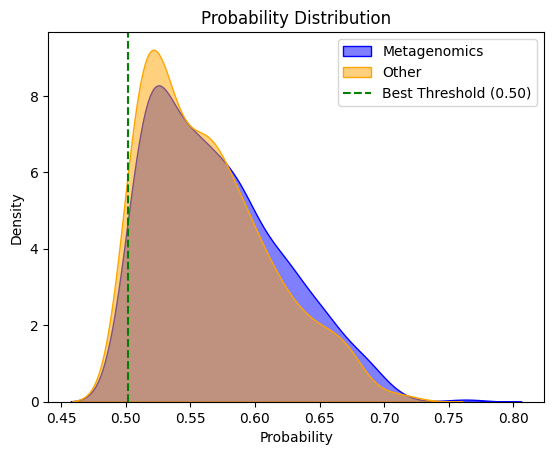

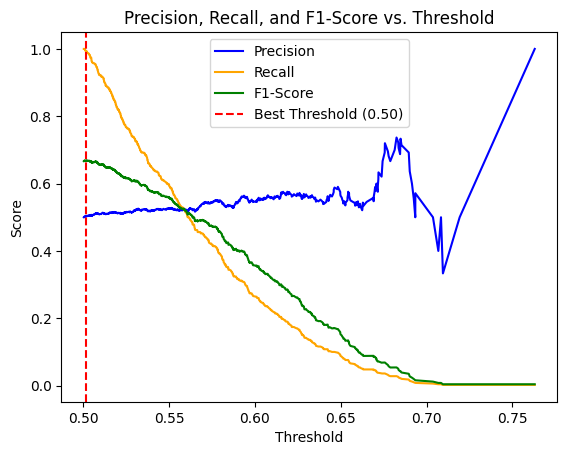

In [162]:
results_auto = evaluate_abstracts_with_visualization(data, classify_sentence)

In [167]:
pprint(results_auto['classification_report'])

{'Metagenomics': {'f1-score': 0.6684599865501009,
                  'precision': 0.5035460992907801,
                  'recall': 0.994,
                  'support': 500.0},
 'Other': {'f1-score': 0.03898635477582846,
           'precision': 0.7692307692307693,
           'recall': 0.02,
           'support': 500.0},
 'accuracy': 0.507,
 'macro avg': {'f1-score': 0.35372317066296466,
               'precision': 0.6363884342607746,
               'recall': 0.507,
               'support': 1000.0},
 'weighted avg': {'f1-score': 0.35372317066296466,
                  'precision': 0.6363884342607747,
                  'recall': 0.507,
                  'support': 1000.0}}


Processing abstracts: 100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


Best Threshold: 0.50
Best F1-Score: 0.67


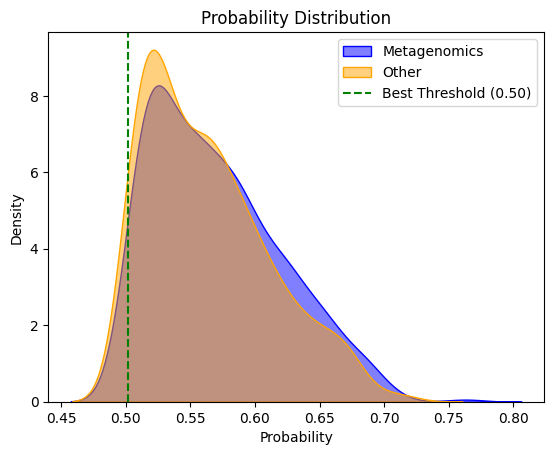

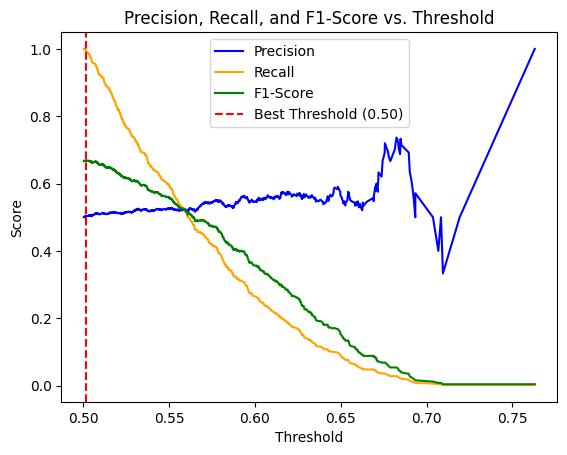

In [163]:
results_custom = evaluate_abstracts_with_visualization(data, classify_sentence_custom)

In [168]:
pprint(results_custom['classification_report'])

{'Metagenomics': {'f1-score': 0.6684599865501009,
                  'precision': 0.5035460992907801,
                  'recall': 0.994,
                  'support': 500.0},
 'Other': {'f1-score': 0.03898635477582846,
           'precision': 0.7692307692307693,
           'recall': 0.02,
           'support': 500.0},
 'accuracy': 0.507,
 'macro avg': {'f1-score': 0.35372317066296466,
               'precision': 0.6363884342607746,
               'recall': 0.507,
               'support': 1000.0},
 'weighted avg': {'f1-score': 0.35372317066296466,
                  'precision': 0.6363884342607747,
                  'recall': 0.507,
                  'support': 1000.0}}


In [157]:
def classify_batch(sentences):
    """
    Classify a batch of sentences and return the predicted labels and probabilities.

    Args:
        sentences (list of str): List of input sentences to classify.

    Returns:
        tuple: (predicted_labels, predicted_probabilities)
    """
    # Preprocess and tokenize the input sentences
    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Predict using the model
    article_model.eval()
    with torch.no_grad():
        outputs = article_model(**inputs)

    # Extract logits
    logits = outputs.logits

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    # Predicted classes and probabilities
    predicted_classes = torch.argmax(probabilities, dim=1).tolist()
    predicted_probabilities = probabilities.max(dim=1).values.tolist()

    # Decode labels
    predicted_labels = label_encoder.inverse_transform(predicted_classes)

    return predicted_labels, predicted_probabilities


In [158]:
def evaluate_abstracts_with_visualization_batch(data, classifier_function, batch_size=16):
    """
    Evaluate abstracts, generate classification metrics, and visualize results.

    Args:
        data (DataFrame): Dataset containing abstracts and true labels.
        classifier_function (function): Function to classify a batch of abstracts.
        batch_size (int): Number of abstracts to process in a single batch.

    Returns:
        dict: Classification report and visualization plots.
    """
    # Store true and predicted labels
    true_labels = []
    predicted_probs = []

    # Iterate through the data in batches
    for i in tqdm(range(0, len(data), batch_size), desc="Processing abstracts"):
        batch = data["abstract"].iloc[i:i + batch_size].tolist()
        true_labels_batch = data["class_label"].iloc[i:i + batch_size].tolist()

        if batch:
            # Use classifier to get predicted labels and probabilities for the batch
            predicted_labels, predicted_probabilities = classifier_function(batch)

            # Append true labels and predicted probabilities
            true_labels.extend([1 if label == "metagenomics" else 0 for label in true_labels_batch])
            predicted_probs.extend(predicted_probabilities)

    # Convert lists to numpy arrays for easier processing
    true_labels = np.array(true_labels)
    predicted_probs = np.array(predicted_probs)

    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probs)

    # Calculate F1-scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero

    # Find the threshold that maximizes F1-score
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index] if thresholds.size > 0 else 0.5
    best_f1_score = f1_scores[best_index]

    # Generate classification report using the best threshold
    predicted_labels = (predicted_probs >= best_threshold).astype(int)
    report = classification_report(true_labels, predicted_labels, target_names=["Other", "Metagenomics"], output_dict=True)

    print(f"Best Threshold: {best_threshold:.2f}")
    print(f"Best F1-Score: {best_f1_score:.2f}")

    # Visualization: Probability Distribution
    plt.figure()
    sns.kdeplot(predicted_probs[true_labels == 1], label="Metagenomics", fill=True, alpha=0.5, color="blue")
    sns.kdeplot(predicted_probs[true_labels == 0], label="Other", fill=True, alpha=0.5, color="orange")
    plt.axvline(x=best_threshold, color="green", linestyle="--", label=f"Best Threshold ({best_threshold:.2f})")
    plt.title("Probability Distribution")
    plt.xlabel("Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Visualization: Precision-Recall vs. Threshold
    plt.figure()
    plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
    plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
    plt.plot(thresholds, f1_scores[:-1], label="F1-Score", color="green")
    plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold ({best_threshold:.2f})")
    plt.title("Precision, Recall, and F1-Score vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    return {
        "classification_report": report,
        "best_threshold": best_threshold,
        "best_f1_score": best_f1_score,
        "probabilities": predicted_probs,
    }


Processing abstracts: 100%|██████████| 63/63 [02:45<00:00,  2.63s/it]


Best Threshold: 0.50
Best F1-Score: 0.67


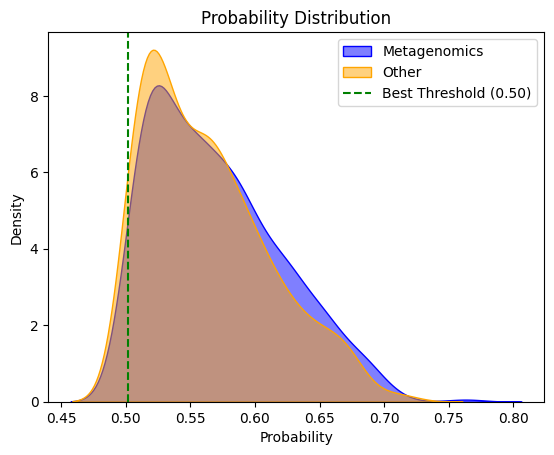

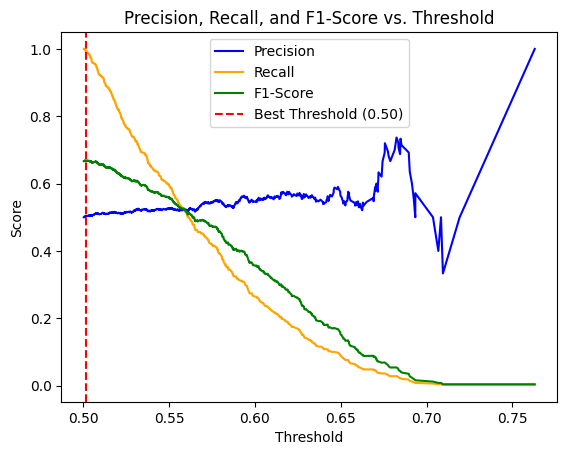

Best Threshold: 0.5017176270484924
Best F1-Score: 0.6684599820863987
{'Metagenomics': {'f1-score': 0.6684599865501009,
                  'precision': 0.5035460992907801,
                  'recall': 0.994,
                  'support': 500.0},
 'Other': {'f1-score': 0.03898635477582846,
           'precision': 0.7692307692307693,
           'recall': 0.02,
           'support': 500.0},
 'accuracy': 0.507,
 'macro avg': {'f1-score': 0.35372317066296466,
               'precision': 0.6363884342607746,
               'recall': 0.507,
               'support': 1000.0},
 'weighted avg': {'f1-score': 0.35372317066296466,
                  'precision': 0.6363884342607747,
                  'recall': 0.507,
                  'support': 1000.0}}


In [159]:
results = evaluate_abstracts_with_visualization(data, classify_batch, batch_size=16)

# Print the best threshold and F1-score
print("Best Threshold:", results["best_threshold"])
print("Best F1-Score:", results["best_f1_score"])

# Print the classification report
from pprint import pprint
pprint(results["classification_report"])


In [170]:
import requests

# ZOOMA API base URL
api_url = "https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate"

# List of terms to map
terms = ["heart disease", "diabetes", "blood pressure"]

# Convert the list of terms into query parameters
query_params = {"propertyValue": ",".join(terms)}

# Send the GET request
response = requests.get(api_url, params=query_params)

# Check the response
if response.status_code == 200:
    print("Ontology mappings:")
    print(response.json())  # Print JSON mappings
else:
    print(f"Failed to fetch mappings. Status code: {response.status_code}")
    print("Response:", response.text)


Ontology mappings:
[{'uri': None, 'annotatedProperty': {'uri': None, 'propertyType': None, 'propertyValue': 'abnormal systemic arterial blood pressure'}, '_links': {'olslinks': [{'href': 'https://www.ebi.ac.uk/ols4/api/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FMP_0000230', 'semanticTag': 'http://purl.obolibrary.org/obo/MP_0000230'}]}, 'semanticTags': ['http://purl.obolibrary.org/obo/MP_0000230'], 'replacedBy': [], 'replaces': [], 'derivedFrom': {'uri': 'http://rdf.ebi.ac.uk/resource/zooma/annotation_summary/OLS', 'annotatedProperty': {'uri': None, 'propertyType': None, 'propertyValue': 'abnormal systemic arterial blood pressure'}, '_links': {'olslinks': [{'href': 'http://purl.obolibrary.org/obo/MP_0000230', 'semanticTag': 'http://purl.obolibrary.org/obo/MP_0000230'}]}, 'semanticTags': ['http://purl.obolibrary.org/obo/MP_0000230'], 'replacedBy': [], 'replaces': [], 'annotatedBiologicalEntities': [], 'provenance': {'source': {'type': 'ONTOLOGY', 'name': 'http://purl.obolibrary.o

In [190]:
import requests
from concurrent.futures import ThreadPoolExecutor

def fetch_zooma_mapping(term):
    """
    Fetch ontology mapping for a single term from the ZOOMA API.

    Args:
        term (str): The term to map.

    Returns:
        tuple: A tuple containing the term and its corresponding URI.
    """
    url = "https://www.ebi.ac.uk/spot/zooma/v2/api/services/annotate"
    try:
        params = {'propertyValue': term}
        response = requests.get(url, params=params, timeout=10)
        if response.status_code == 200:
            rjson = response.json()
            if rjson:
                # Assuming we take the first result
                result = rjson[0]
                links = result.get("_links", {}).get("olslinks", [])
                if links:
                    return term, links[0].get("semanticTag", "#")
        return term, "#"
    except requests.exceptions.RequestException as e:
        print(f"Error fetching term '{term}': {e}")
        return term, "#"

def get_batch_mappings_from_zooma(terms, max_workers=5):
    """
    Fetch ontology mappings for a list of terms from the ZOOMA API using parallel requests.

    Args:
        terms (list): List of terms to map.
        max_workers (int): Number of threads for parallel requests.

    Returns:
        dict: A dictionary with terms as keys and their corresponding URIs as values.
    """
    term_uris = {}
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(fetch_zooma_mapping, terms)
        term_uris = {term: uri for term, uri in results}
    return term_uris

# Test terms
terms = ['covid19', 'december', 'heart disease', 'diabetes', 'blood pressure', 'biopsy']
results = get_batch_mappings_from_zooma(terms)

# Print the results
for term, uri in results.items():
    print(f"Term: {term}, URI: {uri}")


Term: covid19, URI: http://purl.obolibrary.org/obo/MONDO_0100096
Term: december, URI: http://purl.obolibrary.org/obo/NCIT_C106192
Term: heart disease, URI: http://www.ebi.ac.uk/efo/EFO_0003777
Term: diabetes, URI: http://www.ebi.ac.uk/efo/EFO_0000400
Term: blood pressure, URI: http://www.ebi.ac.uk/efo/EFO_0004325
Term: biopsy, URI: http://www.ebi.ac.uk/efo/EFO_0009120


In [189]:
get_batch_mappings_from_zooma(terms)

{'covid19': ('http://purl.obolibrary.org/obo/MONDO_0100096', 'COVID19'),
 'december': ('http://purl.obolibrary.org/obo/NCIT_C106192', 'December'),
 'heart disease': ('http://www.ebi.ac.uk/efo/EFO_0003777', 'heart disease'),
 'diabetes': ('http://www.ebi.ac.uk/efo/EFO_0000400', 'diabetes'),
 'blood pressure': ('http://www.ebi.ac.uk/efo/EFO_0004325', 'Blood pressure'),
 'biopsy': ('http://www.ebi.ac.uk/efo/EFO_0009120', 'biopsy'),
 'InDiA': ('http://purl.obolibrary.org/obo/NCIT_C16727', 'India')}